In [26]:
%%bigquery
CREATE OR REPLACE VIEW asmi_bq.ml_final AS (
  SELECT
    unique_id,
    addToCart,
    visitNumber,
    IFNULL(pageviews_per_session, 0) AS pageviews,
    IFNULL(time_on_site, 0) AS time_on_site,
    IFNULL(traffic_source, '') AS traffic_source,
    IFNULL(device_category, '') AS device_category,
    IFNULL(country, '') AS country,
    IFNULL(channelGrouping, '') AS channelGrouping,
    IFNULL(city, '') AS city,
    IFNULL(operating_system, '') AS operating_system,
    IFNULL(traffic_medium, '') AS traffic_medium,
    IFNULL(traffic_campaign, '') AS traffic_campaign,
    IFNULL(visits, 0) AS visits,
    IFNULL(hits,0) As hits,
    -- BQML Hyperparameter tuning requires STRING 3 partition data_split column.
    -- 80% 'TRAIN' | 10%'EVAL' | 10% 'TEST'
    CASE
      WHEN ABS(MOD(FARM_FINGERPRINT(unique_id), 10)) <= 7 THEN 'TRAIN'
      WHEN ABS(MOD(FARM_FINGERPRINT(unique_id), 10)) = 8 THEN 'EVAL'
      WHEN ABS(MOD(FARM_FINGERPRINT(unique_id), 10)) = 9 THEN 'TEST'
      ELSE '' 
    END AS data_split
  FROM
    `york-bb-cohort.asmi_bq.data1`
);

SELECT * FROM asmi_bq.ml_final
LIMIT 10;


Query is running:   0%|          |

Downloading:   0%|          |

,unique_id,addToCart,visitNumber,pageviews,time_on_site,traffic_source,device_category,country,channelGrouping,city,operating_system,traffic_medium,traffic_campaign,visits,hits,data_split
0,830538748733281778714843391201,0,1,1,0,(direct),mobile,India,Direct,Bengaluru,Android,(none),(not set),1,1,TRAIN
1,848491770781443016114843626611,0,1,1,0,(direct),mobile,United States,Direct,not available in demo dataset,Android,(none),(not set),1,1,TRAIN
2,652121070180585940114843155111,0,12,1,0,(direct),desktop,Spain,Organic Search,Barcelona,Macintosh,(none),(not set),1,1,TRAIN
3,745013611418081526114843107891,0,2,1,0,(direct),desktop,Portugal,Direct,not available in demo dataset,Windows,(none),(not set),1,1,TRAIN
4,186494330309018627814842997901,0,1,1,0,(direct),mobile,United Kingdom,Organic Search,not available in demo dataset,Android,(none),(not set),1,1,TRAIN
5,487041808445078569214843132531,0,1,1,0,(direct),desktop,United States,Organic Search,not available in demo dataset,Chrome OS,(none),(not set),1,1,TRAIN
6,274018545339834079214843362661,0,1,1,0,(direct),mobile,United States,Direct,New York,Android,(none),(not set),1,1,TRAIN
7,215852428235521909614843385961,0,2,1,0,(direct),tablet,Bahrain,Organic Search,not available in demo dataset,iOS,(none),(not set),1,1,EVAL
8,288442388263342554014843038501,0,1,1,0,(direct),desktop,United Kingdom,Organic Search,not available in demo dataset,Macintosh,(none),(not set),1,1,TRAIN
9,544946327582587044014843484721,0,1,1,0,(direct),mobile,Thailand,Direct,Bangkok,Android,(none),(not set),1,1,TRAIN


In [27]:
%%bigquery

CREATE OR REPLACE MODEL asmi_bq.classifier

OPTIONS(
  MODEL_TYPE="BOOSTED_TREE_CLASSIFIER",
  # Declare label column.
  INPUT_LABEL_COLS=["addToCart"],
  # Specify custom data splitting using the `data_split` column.
  DATA_SPLIT_METHOD="CUSTOM",
  DATA_SPLIT_COL="data_split",
  # Enable Vertex Explainable AI aggregated feature attributions.
  ENABLE_GLOBAL_EXPLAIN=True,
  # Hyperparameter tuning arguments.
  num_trials=8,
  max_parallel_trials=4,
  HPARAM_TUNING_OBJECTIVES=["roc_auc"],
  EARLY_STOP=True,
  # Hyperpameter search space.
  LEARN_RATE=HPARAM_RANGE(0.01, 0.1),
  MAX_TREE_DEPTH=HPARAM_CANDIDATES([5,6]),
  AUTO_CLASS_WEIGHTS = True
) AS

SELECT
  * EXCEPT(unique_id)
FROM
  asmi_bq.ml_final

Query is running:   0%|          |

""


In [29]:
%%bigquery
SELECT *
FROM
  ML.TRIAL_INFO(MODEL `asmi_bq.classifier`);

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,hyperparameters,hparam_tuning_evaluation_metrics,training_loss,eval_loss,status,error_message,is_optimal
0,1,"{'learn_rate': 0.1, 'max_tree_depth': 6}",{'roc_auc': 0.8011618381618382},0.529792,0.533689,SUCCEEDED,None,False
1,2,"{'learn_rate': 0.08029516847928717, 'max_tree_...",{'roc_auc': 0.7947472527472528},0.549252,0.548522,SUCCEEDED,None,False
2,3,"{'learn_rate': 0.05871914260703095, 'max_tree_...",{'roc_auc': 0.7947262737262737},0.570302,0.569234,SUCCEEDED,None,False
3,4,"{'learn_rate': 0.03539472084065803, 'max_tree_...",{'roc_auc': 0.7867122877122877},0.613697,0.614583,SUCCEEDED,None,False
4,5,"{'learn_rate': 0.1, 'max_tree_depth': 5}",{'roc_auc': 0.7958801198801199},0.540575,0.540199,SUCCEEDED,None,False
5,6,"{'learn_rate': 0.08601708961125659, 'max_tree_...",{'roc_auc': 0.79901998001998},0.535179,0.538266,SUCCEEDED,None,False
6,7,"{'learn_rate': 0.09859642431856044, 'max_tree_...",{'roc_auc': 0.8016703296703297},0.525408,0.529080,SUCCEEDED,None,True
7,8,"{'learn_rate': 0.08601814026814582, 'max_tree_...",{'roc_auc': 0.79901998001998},0.535178,0.538265,SUCCEEDED,None,False


In [28]:
%%bigquery
SELECT
  *
FROM
  ML.EVALUATE(MODEL asmi_bq.classifier)
WHERE trial_id=1;

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,1,0.048736,0.933241,0.554965,0.092635,0.556489,0.799782


In [32]:
%%bigquery df_roc 

SELECT * FROM ML.ROC_CURVE(MODEL asmi_bq.classifier)

Query is running:   0%|          |

Downloading:   0%|          |

<Axes: title={'center': 'AUC-ROC curve'}, xlabel='false_positive_rate'>

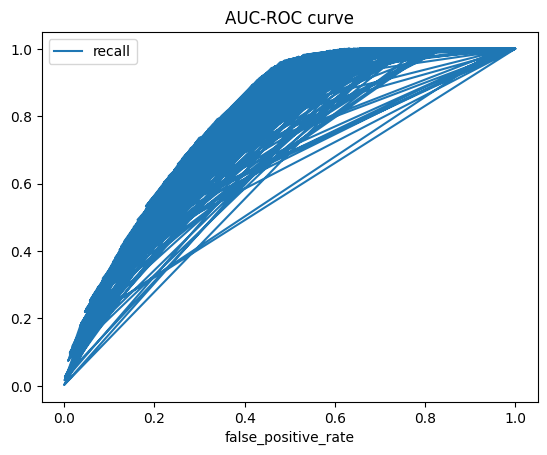

In [33]:
df_roc.plot(x="false_positive_rate", y="recall", title="AUC-ROC curve")

In [34]:
%%bigquery 

SELECT
  *
FROM
  ML.GLOBAL_EXPLAIN(MODEL asmi_bq.classifier)
ORDER BY
  attribution DESC;

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,feature,attribution
0,7,hits,0.464113
1,7,pageviews,0.125035
2,7,time_on_site,0.035240
3,7,visitNumber,0.023024
4,7,country,0.011004
5,7,device_category,0.007318
6,7,operating_system,0.006649
7,7,traffic_source,0.004883
8,7,city,0.002451
9,7,channelGrouping,0.002126


In [35]:
%%bigquery 

SELECT
  *
FROM
  ML.PREDICT(MODEL asmi_bq.classifier,
  (SELECT * FROM asmi_bq.ml_final   WHERE data_split = "TEST"))

Query is running:   0%|          |

Downloading:   0%|          |

,trial_id,predicted_addToCart,predicted_addToCart_probs,unique_id,addToCart,visitNumber,pageviews,time_on_site,traffic_source,device_category,country,channelGrouping,city,operating_system,traffic_medium,traffic_campaign,visits,hits,data_split
0,7,1,"[{'label': 1, 'prob': 0.558452844619751}, {'la...",577198428343717764814844133232,0,2,9,525,(direct),desktop,United States,Organic Search,not available in demo dataset,Windows,(none),(not set),1,13,TEST
1,7,0,"[{'label': 1, 'prob': 0.46167635917663574}, {'...",402597238045705704214844543598,0,2,11,638,(direct),mobile,Canada,Organic Search,Toronto,Android,(none),(not set),1,13,TEST
2,7,1,"[{'label': 1, 'prob': 0.531980574131012}, {'la...",445866508628283383014844349473,0,1,10,113,(direct),mobile,United States,Organic Search,not available in demo dataset,iOS,(none),(not set),1,13,TEST
3,7,0,"[{'label': 1, 'prob': 0.4222599267959595}, {'l...",3893340533924093944148444946613,0,1,13,268,(direct),desktop,Canada,Organic Search,not available in demo dataset,Macintosh,(none),(not set),1,14,TEST
4,7,0,"[{'label': 1, 'prob': 0.49713435769081116}, {'...",301551905529767468314844267463,0,1,12,240,(direct),desktop,United States,Paid Search,not available in demo dataset,Windows,(none),(not set),1,14,TEST
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29532,7,0,"[{'label': 1, 'prob': 0.1349683701992035}, {'l...",32691803203499777514836760661,0,1,1,0,(direct),desktop,United States,Organic Search,not available in demo dataset,Windows,(none),(not set),1,1,TEST
29533,7,0,"[{'label': 1, 'prob': 0.1349683701992035}, {'l...",084916747413972397714836792051,0,2,1,0,(direct),desktop,United States,Organic Search,not available in demo dataset,Macintosh,(none),(not set),1,1,TEST
29534,7,0,"[{'label': 1, 'prob': 0.1349683701992035}, {'l...",841802313279446060614836161091,0,1,1,0,youtube.com,mobile,Mauritius,Social,not available in demo dataset,Android,referral,(not set),1,1,TEST
29535,7,0,"[{'label': 1, 'prob': 0.1349683701992035}, {'l...",106624132069002890914836387961,0,2,1,0,(direct),mobile,India,Organic Search,Ahmedabad,Android,(none),(not set),1,1,TEST


In [44]:

%%bigquery 

CREATE OR REPLACE TABLE asmi_bq.addtocart_predictions AS (
SELECT
    unique_id,
    addToCart,
    predicted_addToCart,
    predicted_addToCart_probs AS predicted_addToCart_prob
FROM
  ML.PREDICT(MODEL asmi_bq.classifier,
  (SELECT * FROM asmi_bq.ml_final))
);


Query is running:   0%|          |

In [51]:
%%bigquery prediction_result
select * from asmi_bq.addtocart_predictions

Query is running:   0%|          |

Downloading:   0%|          |

In [52]:
print('Actual', prediction_result['addToCart'].value_counts())
print('Predicted',prediction_result['predicted_addToCart'].value_counts())

Actual addToCart
0    292732
1      7342
Name: count, dtype: Int64
Predicted predicted_addToCart
0    160115
1    139959
Name: count, dtype: Int64


In [56]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score

actual = prediction_result['addToCart']
predicted = prediction_result['predicted_addToCart']

# Calculate recall
recall = recall_score(actual, predicted)

# Calculate precision
precision = precision_score(actual, predicted)

# Calculate accuracy
accuracy = accuracy_score(actual, predicted)

# Calculate F1 score
f1 = f1_score(actual, predicted)

# Calculate ROC AUC score
roc_auc = roc_auc_score(actual, predicted)

# Print the metrics
print('Recall:', recall)
print('Precision:', precision)
print('Accuracy:', accuracy)
print('F1 Score:', f1)
print('ROC AUC Score:', roc_auc)


Recall: 0.949060201579951
Precision: 0.0497860087597082
Accuracy: 0.5555596286249391
F1 Score: 0.09460899790225456
ROC AUC Score: 0.747375228756853
